## 1\. Preparation Steps (Stored files, GPU, libraries)

### 1.1 Mounting Google Drive to access files on Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 1.2 Unzip dataset

The process of unzipping the file with the command below will be faster compared to manually uploading the entire dataset to Google Drive: It takes about 15 seconds instead of 30 minutes when uploading manually.

**Note**: After unzipping, the data will be stored in the temporary storage of Google Colab, which will be reset after each session as shown in the figure below:

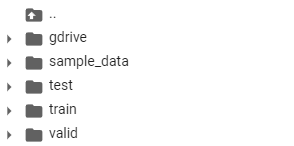

In [2]:
!unzip gdrive/MyDrive/CodeProjects/Algorithms/dataset/dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/rings/022.jpg     
  inflating: train/rings/023.jpg     
  inflating: train/rings/024.jpg     
  inflating: train/rings/025.jpg     
  inflating: train/rings/026.jpg     
  inflating: train/rings/027.jpg     
  inflating: train/rings/028.jpg     
  inflating: train/rings/029.jpg     
  inflating: train/rings/030.jpg     
  inflating: train/rings/031.jpg     
  inflating: train/rings/032.jpg     
  inflating: train/rings/033.jpg     
  inflating: train/rings/034.jpg     
  inflating: train/rings/035.jpg     
  inflating: train/rings/036.jpg     
  inflating: train/rings/037.jpg     
  inflating: train/rings/038.jpg     
  inflating: train/rings/039.jpg     
  inflating: train/rings/040.jpg     
  inflating: train/rings/041.jpg     
  inflating: train/rings/042.jpg     
  inflating: train/rings/043.jpg     
  inflating: train/rings/044.jpg     
  inflating: train/rings/045.jpg     
  inflating: train/rings/046.jp

### 1.3 Import the necessary libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions


plt.rcParams['figure.figsize']= (20,8)

### 1.4 Check GPU for training model

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2\. Preparing data for model

### 2.1 Reading dataset

tf.keras.preprocessing.image_dataset_from_directory function in TensorFlow to create a tf.data.Dataset from images in the specified directory. Some important parameters include:
- directory: Path to the directory containing image data
- label_mode: Selects the label mode, here set to 'categorical' for using one-hot encoding.
- batch_size: Size of data batches.
- interpolation: Interpolation method used when resizing images.

In [2]:
img_size = 224
batch_size= 20

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./train', labels='inferred',
    label_mode='categorical', class_names=None, batch_size=batch_size,
    image_size=(img_size,img_size), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./valid', labels='inferred',
    label_mode='categorical', class_names=None, batch_size=batch_size,
    image_size=(img_size,img_size), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./test', labels='inferred',
    label_mode='categorical', class_names=None, batch_size=batch_size,
    image_size=(img_size,img_size), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False
)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


### 2.2 Visualizing our data

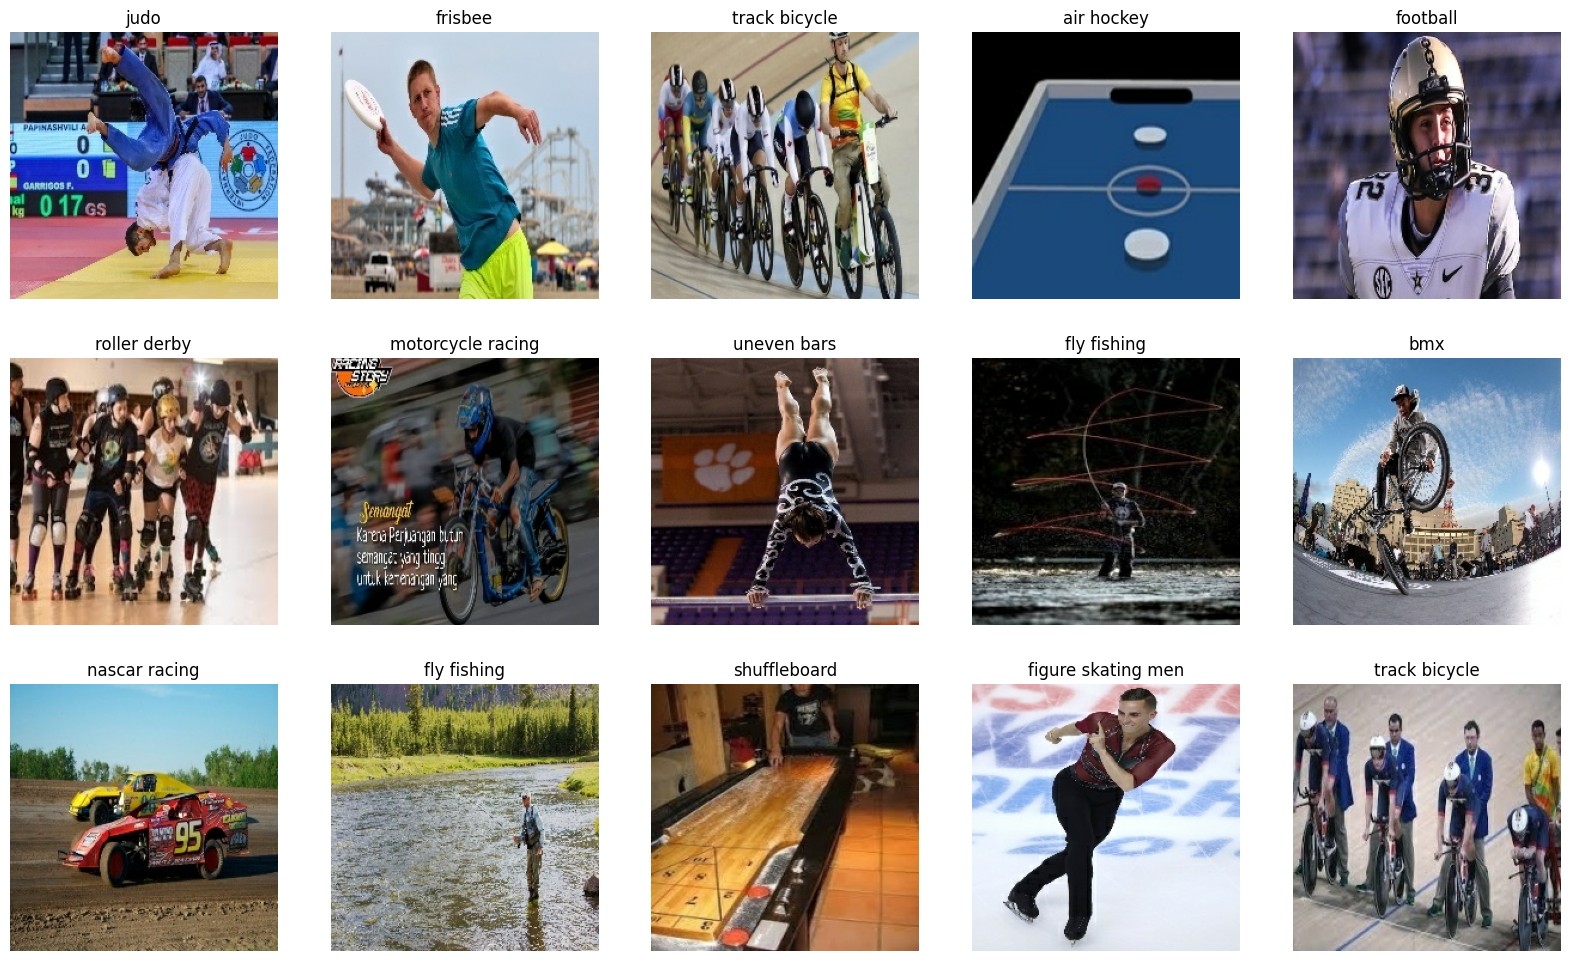

In [6]:
class_names = train_data.class_names
plt.figure(figsize=(20,12))
for x in train_data.take(1):
    for i in range(15):
        plt.subplot(3,5,i+1)
        image = x[0][i] / 255.
        plt.imshow(image)
        label_index = np.argmax(x[1][i].numpy())
        plt.title(class_names[label_index])
        plt.axis('off')

## 3\. Transfer Learning using Pre-trained model

### 3.1 What is transfer learning?


Transfer learning is a machine learning technique where a model trained on one task is adapted for a second related task. Instead of training a model from scratch, transfer learning leverages the knowledge gained from solving a source task and applies it to a target task. This can significantly reduce the amount of labeled data required for training and often leads to improved performance, especially when the source and target tasks share common patterns or features.

### 3.2 ResNet-50

ResNet-50 is a convolutional neural network architecture that belongs to the ResNet (Residual Network) family. Developed by Microsoft Research, ResNet-50 is specifically known for its deep structure and the use of residual learning blocks. The "50" in its name indicates the network's depth, which includes 50 layers.

ResNet-50 introduces the concept of residual learning, where shortcut connections (skip connections) are used to skip one or more layers. This helps in addressing the vanishing gradient problem, allowing the network to effectively train very deep models. ResNet-50 has been widely used in computer vision tasks, such as image classification and object detection, and has demonstrated state-of-the-art performance in various benchmarks.

### 3.3 Building Model using different optimization algorithms

#### 3.3.1 Building general model

<div align="center">
  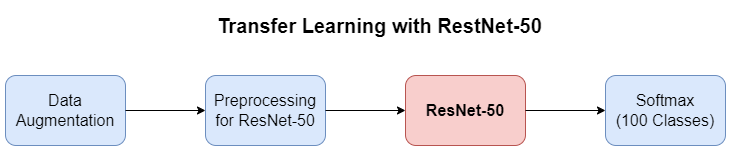
</div>

#### 3.3.2 Model Using Gradient Descent

Construct a sequential model incorporating data augmentation, preprocessing layers for ResNet, ResNet, and a dense layer with softmax activation for multi-class classification.

In [8]:
resnet_weights_path = 'imagenet'
model_gd = Sequential()

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomFlip("horizontal",),
    tf.keras.layers.RandomZoom(0.1),
])
model_gd.add(data_augmentation)

# Utilize the Lambda layer to integrate the preprocess_input for reasonable input to ResNet.
model_gd.add(tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input))

model_gd.build((None, 224, 224, 3))

model_gd.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
model_gd.add(Dense(100, activation='softmax'))
model_gd.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
Total params: 23792612 (90.76 MB)
Trainable params: 23739492 (90.56 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


We will set the ResNet-50 model's trainable paramter to False to prevent the pre-trained weights from being updated during the training process.

In [9]:
model_gd.layers[2].trainable = False

Configure the optimization algorithm as stochastic gradient descent with learning rate $0.001$, the loss function as cross-entropy, and the metric for tracking as accuracy.

**Note**: In TensorFlow, we use tf.keras.optimizers.SGD for regular gradient descent and gradient descent with momentum.

In [10]:
gd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_gd.compile(optimizer= gd_optimizer,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

Training the model, saving the training history, and printing the training time on the screen.

In [11]:
import time

# Record the start time
start_time = time.time()

history_gd = model_gd.fit(train_data,
                    validation_data = val_data, epochs = 8)

# Record the end time
end_time = time.time()

# Calculate the total running time
total_time = end_time - start_time

print(f"\nTotal training time: {total_time} seconds")

Epoch 1/8
675/675 [==============================] - 64s 83ms/step - loss: 4.2239 - accuracy: 0.0966 - val_loss: 3.3400 - val_accuracy: 0.2060
Epoch 2/8
675/675 [==============================] - 54s 79ms/step - loss: 2.9375 - accuracy: 0.3410 - val_loss: 2.3081 - val_accuracy: 0.4800
Epoch 3/8
675/675 [==============================] - 53s 79ms/step - loss: 2.2246 - accuracy: 0.5144 - val_loss: 1.7316 - val_accuracy: 0.6260
Epoch 4/8
675/675 [==============================] - 53s 79ms/step - loss: 1.8134 - accuracy: 0.6101 - val_loss: 1.3924 - val_accuracy: 0.7020
Epoch 5/8
675/675 [==============================] - 54s 79ms/step - loss: 1.5401 - accuracy: 0.6705 - val_loss: 1.1757 - val_accuracy: 0.7420
Epoch 6/8
675/675 [==============================] - 54s 79ms/step - loss: 1.3642 - accuracy: 0.7049 - val_loss: 1.0255 - val_accuracy: 0.7700
Epoch 7/8
675/675 [==============================] - 54s 80ms/step - loss: 1.2217 - accuracy: 0.7313 - val_loss: 0.9178 - val_accuracy: 0.7860

Creating a function to plot the learning curve (reusable for subsequent algorithms):

In [12]:
def plot_history(history):
    history_dict = history.history

    fig, ax = plt.subplots(1, 2, figsize=(30, 10))

    ax[0].plot(list(range(len(history_dict['loss']))), history_dict["loss"], 'ro-', lw=3, markersize=8, label="training loss")
    ax[0].plot(list(range(len(history_dict['loss']))), history_dict["val_loss"], 'b^-', lw=3, markersize=8, label="validation loss")

    ax[1].plot(list(range(len(history_dict['loss']))), history_dict["accuracy"], 'ro-', lw=3, markersize=8, label="training accuracy")
    ax[1].plot(list(range(len(history_dict['loss']))), history_dict["val_accuracy"], 'b^-', lw=3, markersize=8, label="validation accuracy")

    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper left")

    ax[0].set_xlabel("epochs", fontsize=12, weight='bold')
    ax[1].set_xlabel("epochs", fontsize=12, weight='bold')

    ax[0].set_ylabel("loss", fontsize=12, weight='bold')
    ax[1].set_ylabel("accuracy", fontsize=12, weight='bold')

    fig.text(0.515, .93, "Model learning curves", ha="center", va="top", fontsize=18, weight='bold')
    plt.show()

Visualizing our model's learning curves

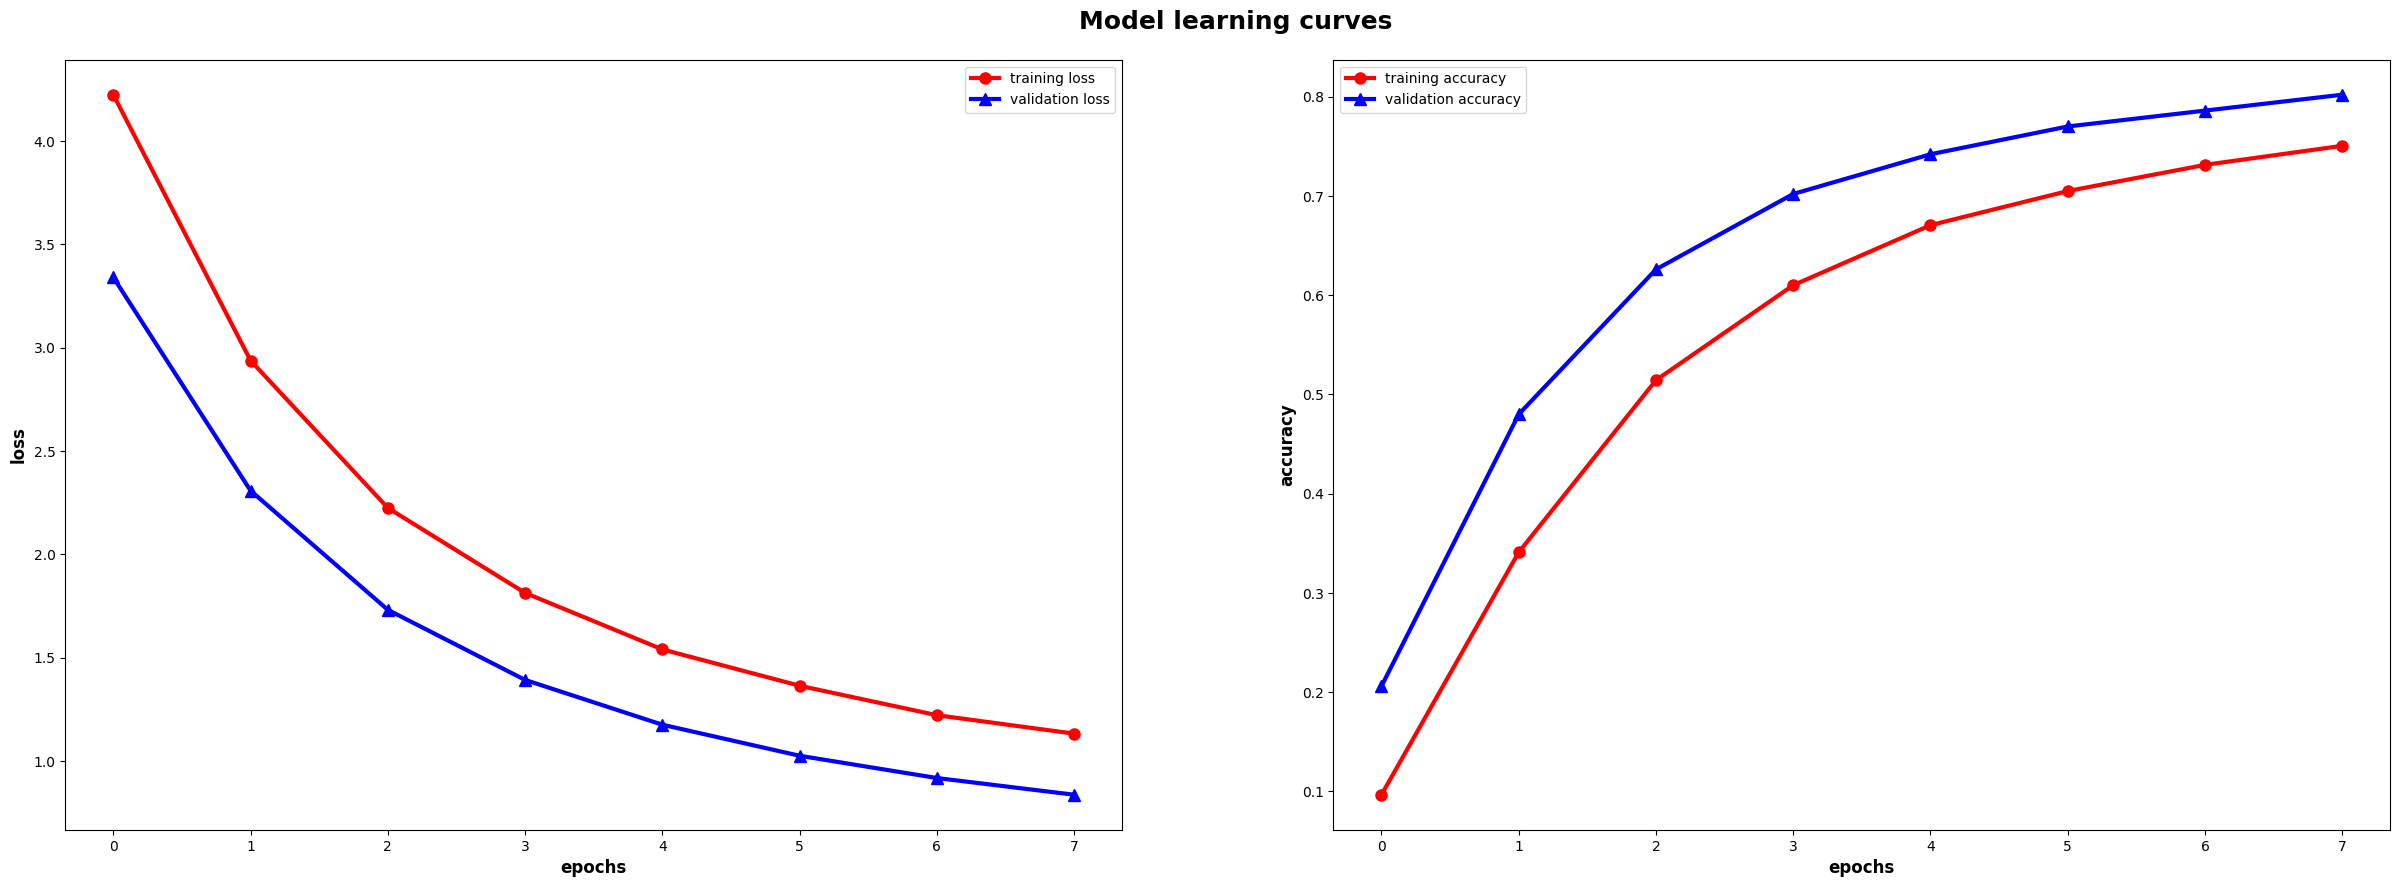

In [13]:
plot_history(history_gd)

Evaluating our model's performance on the test set

In [14]:
tester = model_gd.evaluate(test_data)

print("Loss of the model is - " , tester[0])
print("Accuracy of the model is - " , tester[1]*100 , "%")

25/25 [==============================] - 2s 67ms/step - loss: 0.7977 - accuracy: 0.8220
Loss of the model is -  0.7976512908935547
Accuracy of the model is -  82.20000267028809 %


Saving the model

In [15]:
model_gd.save('sports_classification_with_gd.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### 3.3.3 Model using RMSprop

We will proceed to train the model using the RMSprop optimization algorithm with the default hyperparameters provided by TensorFlow (following similar steps as with SGD):
- Learning rate: $0.001$
- Decay: $0.999$
- epsilon: $10^{-8}$

In [16]:
resnet_weights_path = 'imagenet'
model_RMSprop = Sequential()

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomFlip("horizontal",),
    tf.keras.layers.RandomZoom(0.1),
])
model_RMSprop.add(data_augmentation)

# Utilize the Lambda layer to integrate the preprocess_input for reasonable input to ResNet.
model_RMSprop.add(tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input))
model_RMSprop.build((None, 224, 224, 3))

model_RMSprop.add(ResNet50(include_top = False, pooling = 'avg',
                  weights = resnet_weights_path))
model_RMSprop.add(Dense(100, activation = 'softmax'))
model_RMSprop.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 100)               204900    
                                                                 
Total params: 23792612 (90.76 MB)
Trainable params: 23739492 (90.56 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [17]:
model_RMSprop.layers[2].trainable = False

In [18]:
RMSprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.999, epsilon=1e-8)
model_RMSprop.compile(optimizer=RMSprop_optimizer,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [19]:
import time

# Record the start time
start_time = time.time()

history_RMSprop = model_RMSprop.fit(train_data,
                    validation_data = val_data, epochs = 8)

# Record the end time
end_time = time.time()

# Calculate the total running time
total_time = end_time - start_time

print(f"\nTotal training time: {total_time} seconds")

Epoch 1/8
675/675 [==============================] - 58s 80ms/step - loss: 3.2024 - accuracy: 0.6396 - val_loss: 0.4115 - val_accuracy: 0.8780
Epoch 2/8
675/675 [==============================] - 53s 78ms/step - loss: 0.5063 - accuracy: 0.8518 - val_loss: 0.3624 - val_accuracy: 0.8860
Epoch 3/8
675/675 [==============================] - 54s 79ms/step - loss: 0.3624 - accuracy: 0.8900 - val_loss: 0.4216 - val_accuracy: 0.8980
Epoch 4/8
675/675 [==============================] - 53s 78ms/step - loss: 0.2883 - accuracy: 0.9112 - val_loss: 0.3487 - val_accuracy: 0.8940
Epoch 5/8
675/675 [==============================] - 53s 78ms/step - loss: 0.2501 - accuracy: 0.9205 - val_loss: 0.4451 - val_accuracy: 0.8880
Epoch 6/8
675/675 [==============================] - 54s 80ms/step - loss: 0.2141 - accuracy: 0.9314 - val_loss: 0.4467 - val_accuracy: 0.8740
Epoch 7/8
675/675 [==============================] - 54s 79ms/step - loss: 0.2027 - accuracy: 0.9340 - val_loss: 0.3833 - val_accuracy: 0.9040

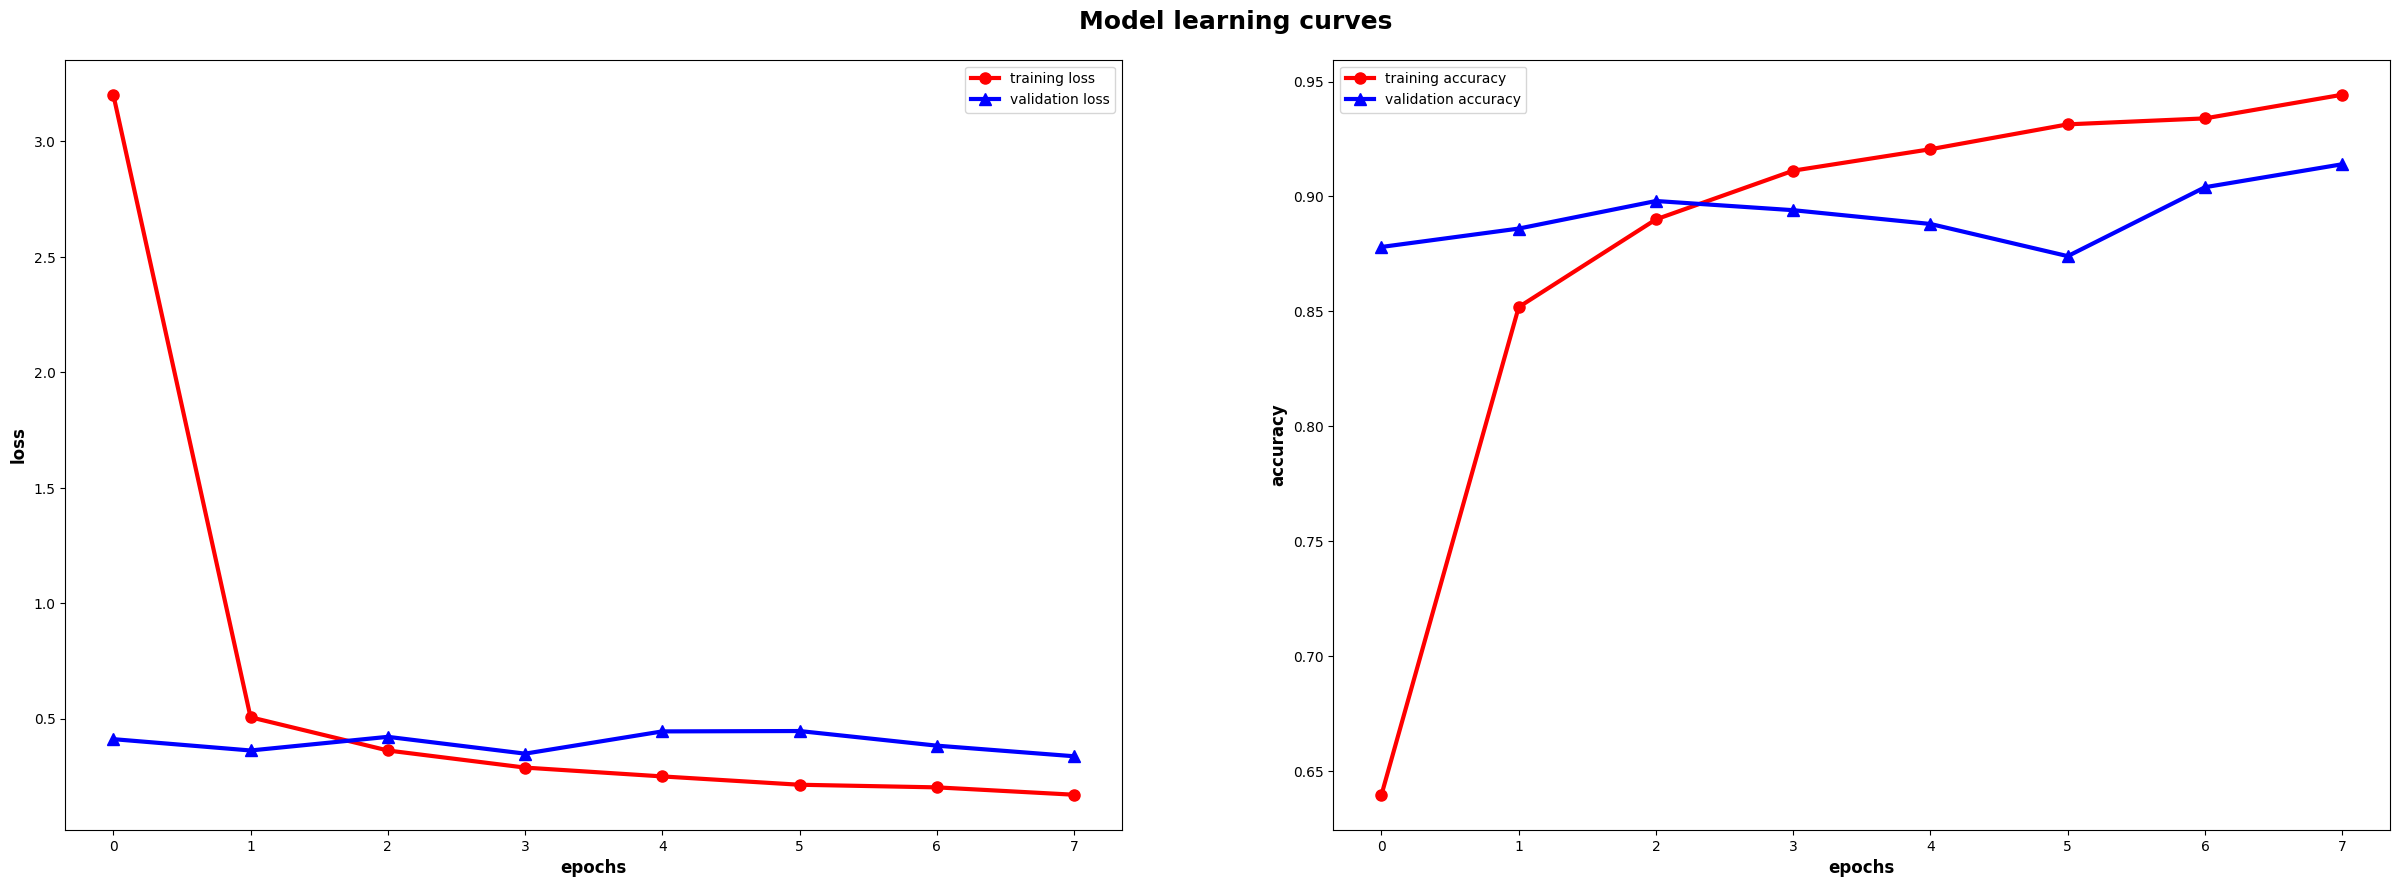

In [20]:
plot_history(history_RMSprop)

In [21]:
tester_RMSprop = model_RMSprop.evaluate(test_data)

print("Loss of the model is - " , tester_RMSprop[0])
print("Accuracy of the model is - " , tester_RMSprop[1]*100 , "%")

25/25 [==============================] - 2s 69ms/step - loss: 0.3690 - accuracy: 0.9200
Loss of the model is -  0.36897045373916626
Accuracy of the model is -  92.00000166893005 %


In [22]:
model_RMSprop.save('sports_classification_with_RMSprop.h5')

#### 3.3.4 Model using Adam

We will proceed to train the model using the RMSprop optimization algorithm with the default hyperparameters provided by TensorFlow (following similar steps as with SGD):
- Learning rate: $0.001$
- $\beta_1$: $0.9$
- $\beta_2$: $0.999$
- epsilon: $10^{-8}$

In [23]:
resnet_weights_path = 'imagenet'
model_adam = Sequential()

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomFlip("horizontal",),
    tf.keras.layers.RandomZoom(0.1),
])
model_adam.add(data_augmentation)

# Utilize the Lambda layer to integrate the preprocess_input for reasonable input to ResNet.
model_adam.add(tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input))
model_adam.build((None, 224, 224, 3))

model_adam.add(ResNet50(include_top = False, pooling = 'avg',
                  weights = resnet_weights_path))
model_adam.add(Dense(100, activation = 'softmax'))
model_adam.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 100)               204900    
                                                                 
Total params: 23792612 (90.76 MB)
Trainable params: 23739492 (90.56 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [24]:
model_adam.layers[2].trainable = False

In [25]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                          beta_2=0.999, epsilon=1e-8)
model_adam.compile(optimizer= adam_optimizer,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [26]:
import time

# Record the start time
start_time = time.time()

history_adam = model_adam.fit(train_data,
                    validation_data = val_data, epochs = 8)

# Record the end time
end_time = time.time()

# Calculate the total running time
total_time = end_time - start_time

print(f"Total training time: {total_time} seconds")


Epoch 1/8
675/675 [==============================] - 58s 80ms/step - loss: 1.3435 - accuracy: 0.6532 - val_loss: 0.4269 - val_accuracy: 0.8640
Epoch 2/8
675/675 [==============================] - 54s 80ms/step - loss: 0.4868 - accuracy: 0.8572 - val_loss: 0.3775 - val_accuracy: 0.8860
Epoch 3/8
675/675 [==============================] - 53s 78ms/step - loss: 0.3612 - accuracy: 0.8903 - val_loss: 0.4306 - val_accuracy: 0.8740
Epoch 4/8
675/675 [==============================] - 53s 78ms/step - loss: 0.2769 - accuracy: 0.9111 - val_loss: 0.3603 - val_accuracy: 0.9080
Epoch 5/8
675/675 [==============================] - 54s 80ms/step - loss: 0.2403 - accuracy: 0.9200 - val_loss: 0.2920 - val_accuracy: 0.9180
Epoch 6/8
675/675 [==============================] - 55s 81ms/step - loss: 0.2159 - accuracy: 0.9289 - val_loss: 0.3654 - val_accuracy: 0.8960
Epoch 7/8
675/675 [==============================] - 53s 78ms/step - loss: 0.1984 - accuracy: 0.9372 - val_loss: 0.3718 - val_accuracy: 0.9100

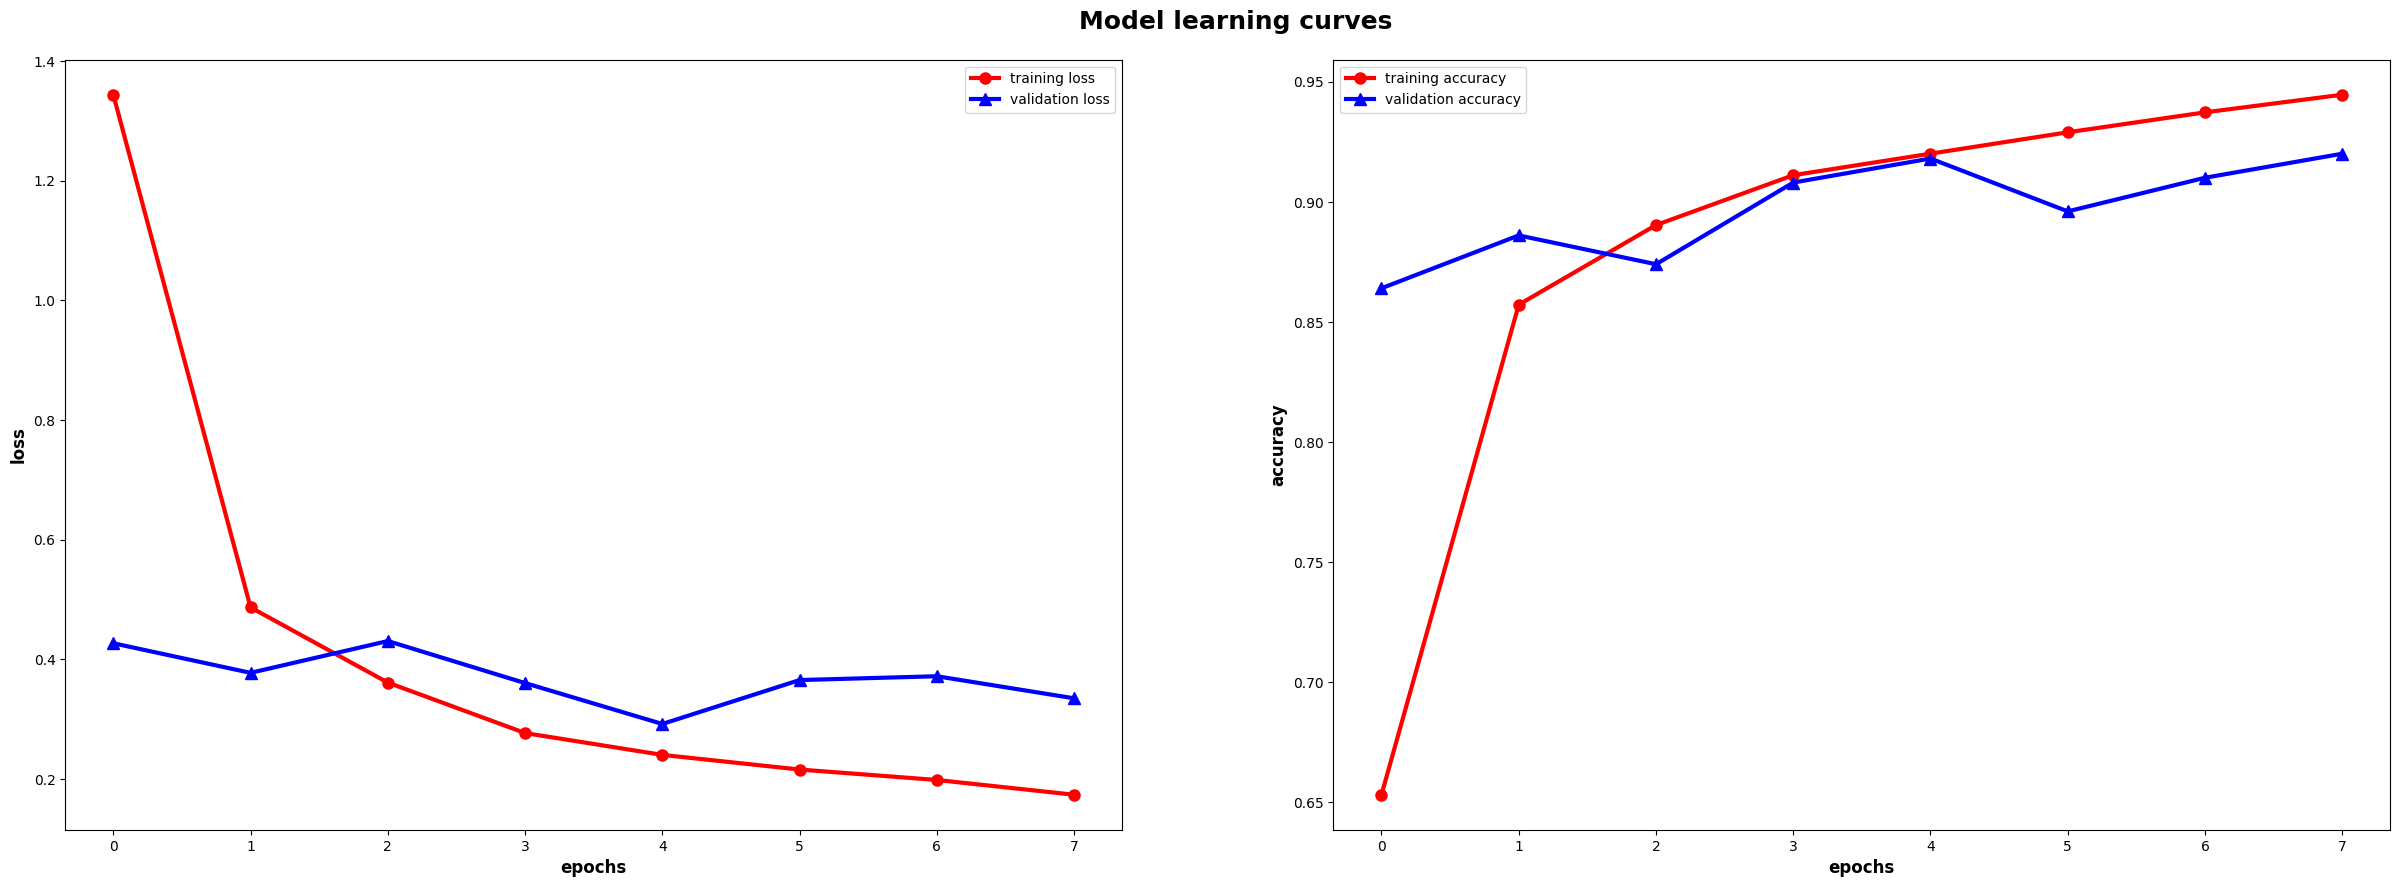

In [27]:
plot_history(history_adam)

In [28]:
tester_adam = model_adam.evaluate(test_data)

print("Loss of the model is - " , tester_adam[0])
print("Accuracy of the model is - " , tester_adam[1]*100 , "%")

25/25 [==============================] - 2s 71ms/step - loss: 0.3032 - accuracy: 0.9180
Loss of the model is -  0.30323106050491333
Accuracy of the model is -  91.79999828338623 %


In [29]:
model_adam.save('sports_classification_with_adam.h5')

## 4\. Summary

Here is a comparison table for a more visual overview:

<div align="center">
  <table>
    <tr>
      <th><b>Optimization Algorithms</b></th>
      <th><b>Accuracy (Train set)</b></th>
      <th><b>Accuracy (Validation set)</b></th>
      <th><b>Accuracy (Test set)</b></th>
      <th><b>Run time</b></th>
    </tr>
    <tr>
      <td>Gradient descent</td>
      <td>75.05%</td>
      <td>80.20%</td>
      <td>82.20%</td>
      <td>546.98s</td>
    </tr>
    <tr>
      <td>RMSprop</td>
      <td>94.43%</td>
      <td>91.40%</td>
      <td>92.00%</td>
      <td>488.94s</td>
    </tr>
    <tr>
      <td>Adam</td>
      <td>94.46%</td>
      <td>92.00%</td>
      <td>91.80%</td>
      <td>489.00s</td>
    </tr>
  </table>
</div>

## 5\. Conclusion

- RMS prop and Adam both have a higher accuracy on the test set than Gradient Descent, at 92.00% and 91.80%, respectively, compared to 82.20% for Gradient Descent. This suggests that RMS prop and Adam can find better model parameters, which helps the model to better predict on new data sets.
- RMS prop and Adam have comparable run times, at 488.94 seconds and 489.00 seconds, respectively, compared to 546.98 seconds for Gradient Descent. This suggests that both algorithms are capable of learning quickly and efficiently.
- Overall, RMS prop and Adam are both effective optimization algorithms for this model and problem. You can choose one of the two algorithms depending on your specific needs. If you need a model with the highest accuracy on a new data set, then RMS prop is the best choice. If you need a model with a fast run time and good accuracy, then Adam is the best choice.

**Note**: The conclusions above are based only on the accuracy metrics on the train, validation, and test data sets. For a more accurate conclusion, you need to evaluate additional metrics such as loss function, precision, recall, F1 score, etc. Additionally, the results may vary depending on other factors such as the data set, model structure, etc.

## 6\. Development Direction (Expansion Section)

In this section, we will not delve too much into optimization algorithms but rather discuss how to make this model work more efficiently through an important step called **Error Analysis**.